In [1]:
#Importing the libraries 
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import sympy as sy
import random

#To display the figures in the converted PDF/HTML files
%matplotlib inline

# Question 1

In [2]:
def calError(inliers,circ_x,circ_y,radius):
    sum_ = 0
    for point in inliers:
        sum_ += abs(np.sqrt((point[0]-circ_x)**2+(point[1]-circ_y)**2) - radius)
    return sum_/len(inliers)

def inRange(point,circ_x,circ_y,a,b): 
    return True if a <= np.sqrt((circ_x-point[0])**2 + (circ_y-point[1])**2) <= b else False

def circle(x,y,z):
    x = complex(x[0],x[1])
    y = complex(y[0],y[1])
    z = complex(z[0],z[1])
    try:
        w = z-x
        w /= y-x
        c = (x-y)*(w-abs(w)**2)/2j/w.imag-x
    except ZeroDivisionError:
        return False,False,False
    
    return (-c.real, -c.imag, abs(c+x)) #(-center_x,-center_y,r)

def bestfitCircle(inlier_dots):
    x,y = inlier_dots[:,0],inlier_dots[:,1]
    N = len(x)
    x_bar,y_bar = np.mean(x),np.mean(y)
    u,v = (x - x_bar),(y - y_bar)
    
    a11 = sum(u**2)
    a12 = a21 = sum(u*v)
    a22 = sum(v**2)
    
    b1 = 0.5*(sum(u*(u**2 + v**2)))
    b2 = 0.5*(sum(v*(u**2 + v**2)))
    
    A = np.array([[a11,a12],[a21,a22]])
    B = np.array([[b1],[b2]])
    u_c, v_c = np.linalg.inv(A) @ B
    
    circ_x = u_c + x_bar
    circ_y = v_c + y_bar
    
    radius = np.sqrt(u_c**2 + v_c**2 + (sum(u**2 + v**2))/(N))
    
    return circ_x, circ_y, radius

def circ_RANSAC(X,N):
    
    e = 0.5     # outlier ratio
    s = 3       # Number of point s need to create the estimate model
    p = 0.97    # Probability to choose number of iteration cycles
    thresh = 1.225  # Threshold distance to determine inliers and outliers
    d = 50      # expected number of inliers
    
    iter_rounds = int(np.log(1-p)/np.log(1-(1-e)**s))
    print("N=",iter_rounds)
    best_samples = []
    best_inliers = []
    best_outliers = []
    best_errors = []
    best_inlier_counts=[]
    
    for i in range(iter_rounds):
        
        [x,y,z] = random.choices(X,k=3)
        circ_x, circ_y, radius = circle(x,y,z)
              
        inliers = []
        outliers = []
        
        if not (circ_x == False and circ_y == False and radius == False):
            a, b = radius - thresh, radius + thresh
            for point in X:
                point=list(point)
                if inRange(point,circ_x,circ_y,a,b):  
                    inliers.append(point)
                else:
                    outliers.append(point)
            
            if len(inliers) >= d:
                error = calError(inliers,circ_x,circ_y,radius)
                best_errors.append(error)
                best_samples.append([x,y,z])
                
                best_inliers.append(inliers)
                best_inlier_counts.append(len(inliers))
                best_outliers.append(outliers)
    
    if len(best_inlier_counts)==0:
        circ_RANSAC(X,N)
    else:   
        best = max(best_inlier_counts)
        best_inlier_counts_np = np.array(best_inlier_counts,dtype=int)
        print(best_inlier_counts,best)
        count = np.count_nonzero(best_inlier_counts_np == best)
        
        if count > 1:
            indexes = np.where(best_inlier_counts_np==best)[0]
            print(indexes)
            print(best_errors)
            min_i = [indexes[0],best_errors[indexes[0]]]
            for j in range(len(best_errors)):
                if (j in indexes) and (best_errors[j]<min_i[1]):
                    min_i = [j,best_errors[j]]
            k = min_i[0]
        else:
            k = best_inlier_counts.index(best)
        print(k)
           
        best_dots = np.array(best_samples[k])
        inlier_dots = np.array(best_inliers[k])
        outlier_dots = np.array(best_outliers[k])
        a,b,c = circle(best_samples[k][0],best_samples[k][1],best_samples[k][2])
        e,f,g = bestfitCircle(inlier_dots)
        
        fig,ax = plt.subplots(figsize=(12,12.5))
        ax.set_xticks([i for i in range(-12,13,2)])
        ax.set_yticks([i for i in range(-10,15,2)])
        
        ax.scatter(inlier_dots[:,0],inlier_dots[:,1],color='y',label='Inliers')
        ax.scatter(outlier_dots[:,0],outlier_dots[:,1],color='b',label='Outliers')
        ax.scatter(best_dots[:,0],best_dots[:,1],color='r',label='Best samples')
        
        best_sample_circle = plt.Circle( (a,b ),c ,fill = False,color = 'b',label='Best sample' )
        RANSAC_circle = plt.Circle( (e,f ),g ,fill = False,color='m',label='RANSAC' )
        print(a,b,c)
        print(e,f,g)
        ax.set_aspect( 1 )
        ax.add_artist( best_sample_circle )
        ax.add_artist( RANSAC_circle )
        
        ax.legend()
        plt.show()


    
    

N= 26
[57] 57
0
0.40018963158601245 -0.1453602521878743 9.608067496350499
[0.28403265] [-0.20217908] [9.8617434]


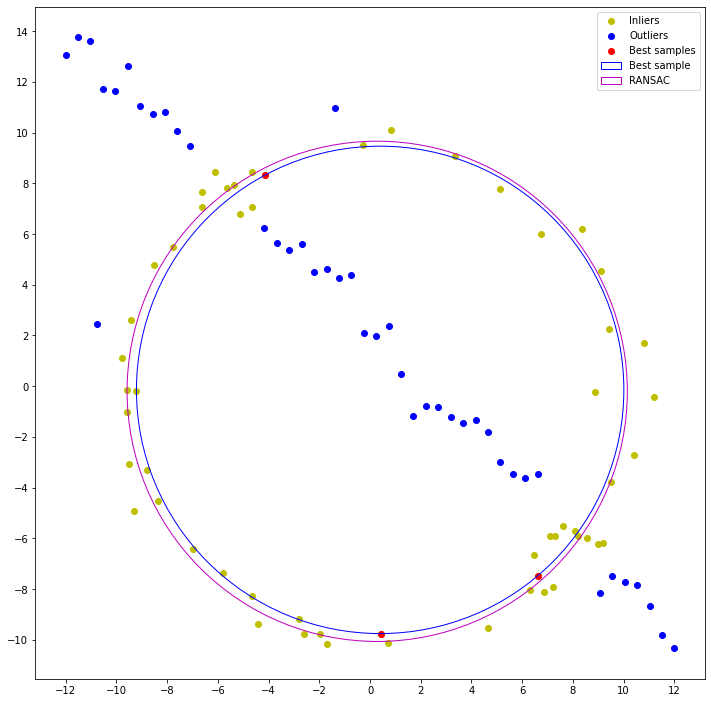

In [12]:
N = 100
half_n = N//2
r = 10
s = r/16
t = np.random.uniform(0,2*np.pi,half_n )
n = s*np.random.randn(half_n)
x,y = (r + n)*np.cos(t),(r+n)*np.sin(t)
X_circ = np.hstack(( x.reshape(half_n,1),y.reshape(half_n,1)))
m,b = -1,2
x = np.linspace(-12, 12 , half_n )
y = m*x + b + s*np.random.randn(half_n)
X_line = np.hstack ( ( x.reshape ( half_n , 1 ) , y.reshape ( half_n , 1 ) ) )
X = np.vstack ( ( X_circ , X_line ) )

circ_RANSAC(X,N)

# Question 2

In [7]:
points = []

def setPoints(x,y):
    global points
    points.append([x,y])
    
def click_event(event, x, y, flags, params):
     
    # checking for left mouse clicks
    if event == cv.EVENT_LBUTTONDOWN:
        setPoints(x,y)
        # displaying the coordinates
        # on the image window
        font = cv.FONT_HERSHEY_SIMPLEX
        cv.circle(img,(x,y),5, (0, 0, 255), -1)
        cv.imshow('image', img)

# reading the image
img = cv.imread('Images/Building/001.jpg', 1)

# displaying the image
cv.imshow('image', img)

# setting mouse handler for the image
# and calling the click_event() function
cv.setMouseCallback('image', click_event)

# wait for a key to be pressed to exit
cv.waitKey(0)

# close the window
cv.destroyAllWindows()


# Read source image.

im_src = cv.imread('Images/flag.jpeg')
w,h = im_src.shape[1],im_src.shape[0]
print(w,h)
# Four corners of the book in source image
pts_src = np.array([[0, 0], [w-1, 0], [w-1, h-1],[0, h-1]])

# Read destination image.
im_dst = cv.imread('Images/Building/001.jpg')

# Four corners of the book in destination image.
pts_dst = np.array(points)

# Calculate Homography
h, status = cv.findHomography(pts_src, pts_dst)

# Warp source image to destination based on homography
im_out = cv.warpPerspective(im_src, h, (im_dst.shape[1],im_dst.shape[0]))
# print(im_out.shape[1],im_out.shape[0])
# # Display images
# cv.imshow("Source Image", im_src)
# cv.imshow("Destination Image", im_dst)
# cv.imshow("Warped Source Image", im_out)
 
# cv.waitKey(0)

# # close the window
# cv.destroyAllWindows()

dim = (800,600)
im_dst_bg = cv.resize(im_dst, dim, interpolation = cv.INTER_AREA)
im_out_bg = cv.resize(im_out, dim, interpolation = cv.INTER_AREA)

blend = cv.addWeighted(im_dst_bg, 1, im_out_bg, 0.6, 0.2)
cv.imshow("Source Image", blend)
cv.waitKey(0)

# close the window
cv.destroyAllWindows()

277 182
